In [1]:
import awkward as ak
import numpy as np
import time
import coffea
import uproot
import hist
import vector
print("awkward version ", ak.__version__)
print("coffea version ", coffea.__version__)
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from collections import defaultdict
import pickle

awkward version  1.10.1
coffea version  0.7.19


In [2]:
#fff = uproot.open(infiles[0])

In [3]:
#fff["Events"]

In [4]:
#fff["Events"].keys()

In [5]:
#np.abs(pdgid.array()) == 11

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
from response_maker_nanov9_lib import *
from response_maker_nanov9 import main

In [8]:
! rm qjetmass_zjets.pkl

In [10]:
main()

Processing files 
UL16NanoAOD
/mnt/data/cms/store/mc/RunIISummer20UL16NanoAODv9/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v2/40000/AFAE20D3-ACCA-7048-9AA2-DF46FFC6E18E.root
/mnt/data/cms/store/mc/RunIISummer20UL16NanoAODv9/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v2/40000/DC17BD26-FB99-9943-A159-B19C836912AD.root
/mnt/data/cms/store/mc/RunIISummer20UL16NanoAODv9/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v2/2430000/64E40ADF-28D3-104F-92F8-2310E0BD7521.root
/mnt/data/cms/store/mc/RunIISummer20UL16NanoAODv9/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v2/2430000/13C0D928-E45B-E243-B36C-550AD6D0F26E.root
/mnt/data/cms/store/mc/RunIISummer20UL16NanoAODv9/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/

Output()

/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.p

In [11]:
with open("qjetmass_zjets.pkl", "rb") as f:
    output = pickle.load( f )

In [12]:
output.keys()

dict_keys(['njet_gen', 'njet_reco', 'ptjet_gen', 'ptjet_reco', 'ptjet_reco_over_gen', 'drjet_reco_gen', 'mz_gen', 'mz_reco', 'mz_reco_over_gen', 'dr_z_jet_gen', 'dr_z_jet_reco', 'dphi_z_jet_gen', 'dphi_z_jet_reco', 'ptasym_z_jet_gen', 'ptasym_z_jet_reco', 'mjet_reco_over_gen', 'dr_gen_subjet', 'cutflow'])

In [13]:
output["cutflow"]

{'UL18NanoAOD': defaultdict(int,
             {'ee total': 81932285,
              'ee nlep >=2': 8443108,
              'ee zpt > 90': 6777534,
              'ee >=1 gen jet': 5141605,
              'ee gen jet pt cut': 4071679,
              'ee gen jet eta cut': 3999767,
              'ee gen jet dphi cut': 3895649,
              'ee gen jet asym cut': 2208057,
              'ee gen jet cuts': 2208057,
              'ee groomed gen jet cuts ': 1531354,
              'ee >=1 reco jet': 62464,
              'ee reco jet cuts': 62464,
              'mm total': 85935406,
              'mm nlep >=2': 12615034,
              'mm zpt > 90': 8399127,
              'mm >=1 gen jet': 6402392,
              'mm gen jet pt cut': 4896000,
              'mm gen jet eta cut': 4805478,
              'mm gen jet dphi cut': 4666222,
              'mm gen jet asym cut': 2540357,
              'mm gen jet cuts': 2540357,
              'mm groomed gen jet cuts ': 1584609,
              'mm >=1 reco jet'

In [14]:
import matplotlib.pyplot as plt

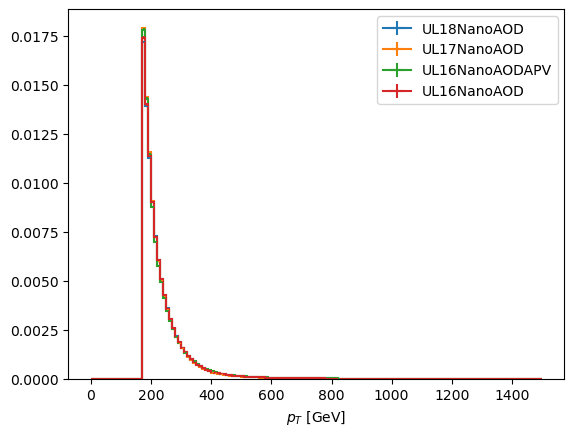

In [15]:
output['ptjet_gen'].stack("dataset").project("pt").plot(density=True)
plt.legend()
plt.show()

In [16]:
output['ptjet_gen'].sum().value

201632.04152695095

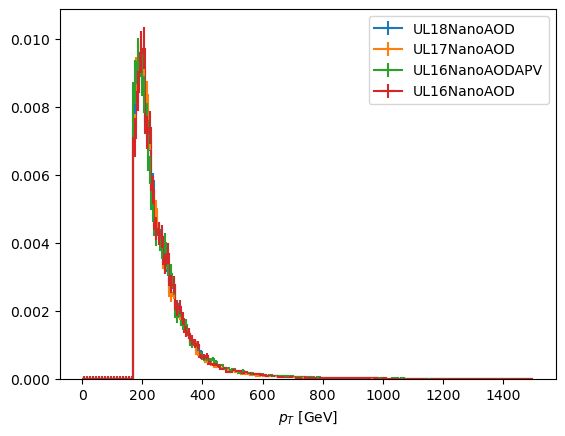

In [17]:
output['ptjet_reco'].stack("dataset").project("pt").plot(density=True)
plt.legend()
plt.show()

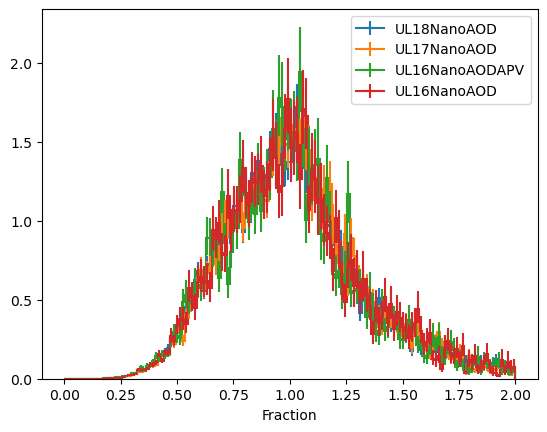

In [18]:
output['ptjet_reco_over_gen'].stack("dataset").project("frac").plot(density=True)
plt.legend()
plt.show()

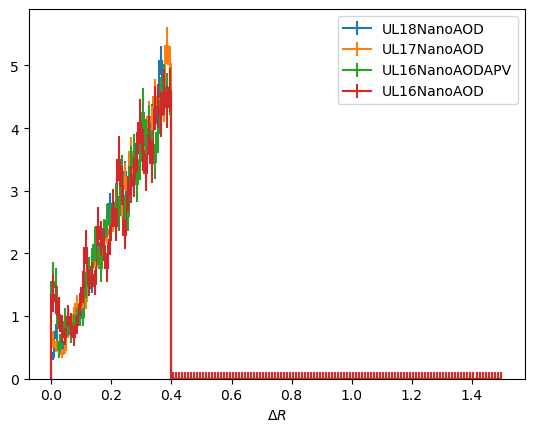

In [19]:
output['drjet_reco_gen'].stack("dataset").project("dr").plot(density=True)
plt.legend()
plt.show()

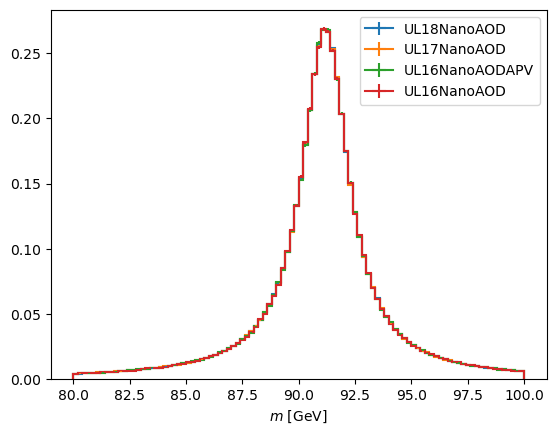

In [20]:
output['mz_gen'].stack("dataset").project("mass").plot(density=True)
plt.legend()
plt.show()

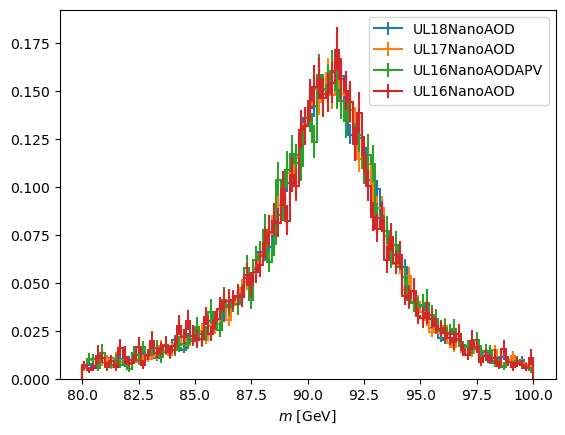

In [21]:
output['mz_reco'].stack("dataset").project("mass").plot(density=True)
plt.legend()
plt.show()

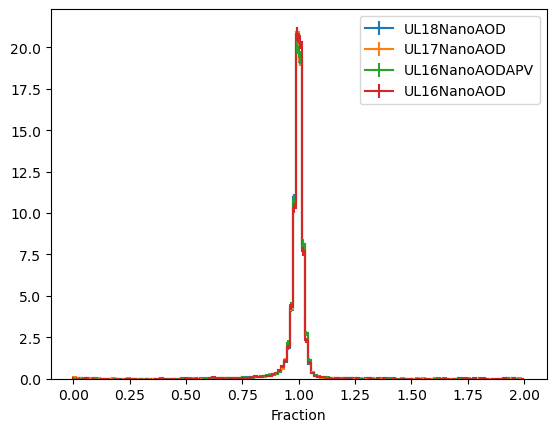

In [22]:
output['mz_reco_over_gen'].stack("dataset").project("frac").plot(density=True)
plt.legend()
plt.show()

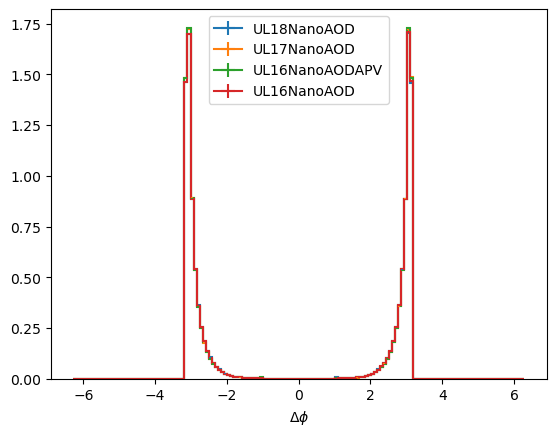

In [23]:
output['dphi_z_jet_gen'].stack("dataset").project("dphi").plot(density=True)
plt.legend()
plt.show()

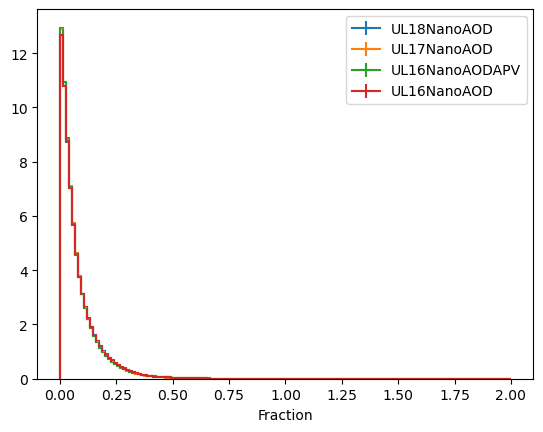

In [24]:
output['ptasym_z_jet_gen'].stack("dataset").project("frac").plot(density=True)
plt.legend()
plt.show()

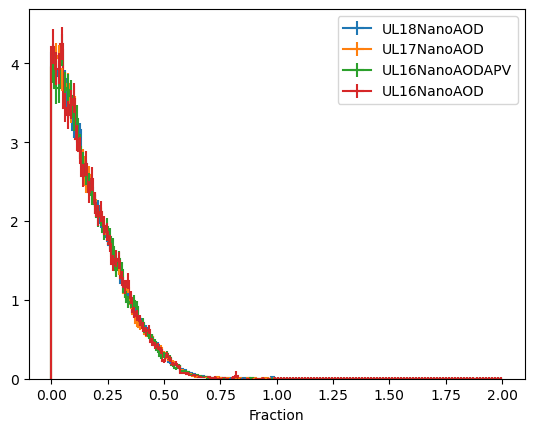

In [25]:
output['ptasym_z_jet_reco'].stack("dataset").project("frac").plot(density=True)
plt.legend()
plt.show()

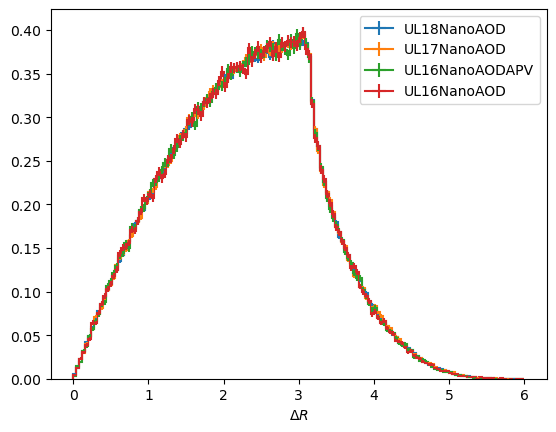

In [26]:
output['dr_z_jet_gen'].stack("dataset").project("dr").plot(density=True)
plt.legend()
plt.show()

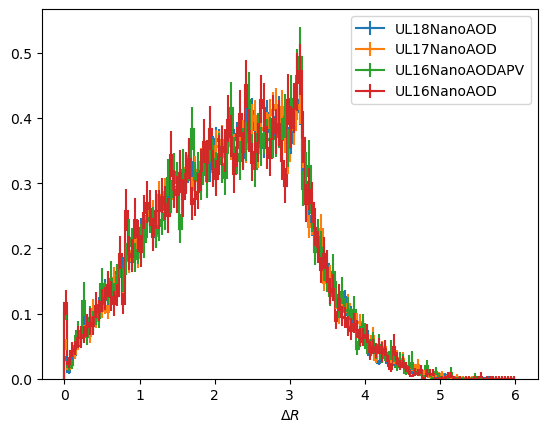

In [27]:
output['dr_z_jet_reco'].stack("dataset").project("dr").plot(density=True)
plt.legend()
plt.show()

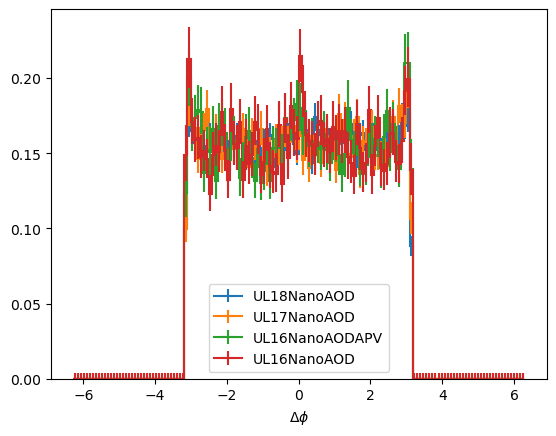

In [28]:
output['dphi_z_jet_reco'].stack("dataset").project("dphi").plot(density=True)
plt.legend()
plt.show()

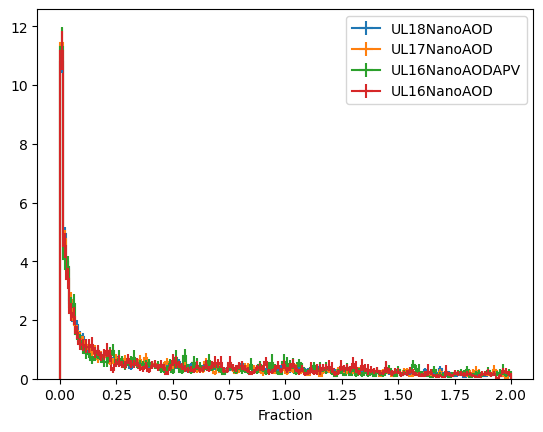

In [29]:
output['mjet_reco_over_gen'].stack("dataset").project("frac").plot(density=True)
plt.legend()
plt.show()

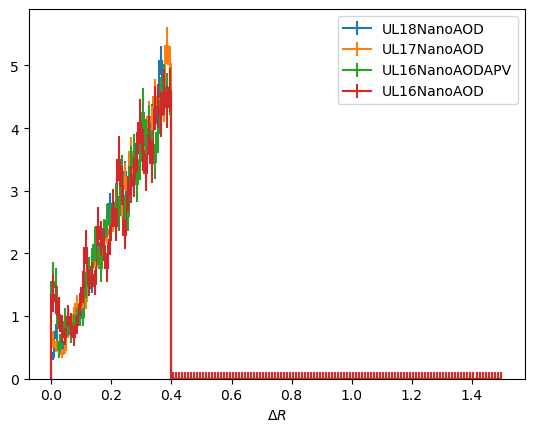

In [30]:
output['drjet_reco_gen'].stack("dataset").project("dr").plot(density=True)
plt.legend()
plt.show()

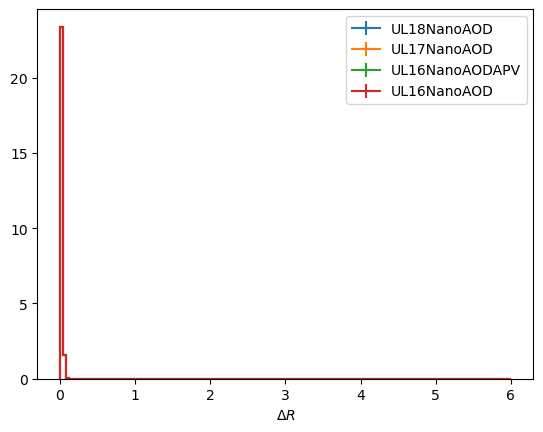

In [31]:
output['dr_gen_subjet'].stack("dataset").project("dr").plot(density=True)
plt.legend()
plt.show()